# Variational Autoencoder

In this exercise you will implement a variational autoencoder on the MNIST dataset.
For that, we will use the Tensorflow library.
So in the first step we will import tensorflow, numpy and matplotlib for plotting.
This tutorial is inspired by https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/variational_autoencoder.py.

In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

To be reproducable, we will set the random seed for numpy and tensorflow:

In [3]:
np.random.seed(3234)
tf.set_random_seed(4345)

Then we load the MNIST dataset and make the image binary (black or white).

In [4]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
images = (x_train >= 128).astype(int)

11493376/11490434 [==============================] - 1s 0us/step


The following function will create a fully connected layer.
If you provide a weight dictionary, it will re-use the weigths if the specified key is in the dictionary.
If it is not yet present, it will add the weights.

In [5]:
def fully(x, neurons, weight_dict=None, weight_dict_key='fc'):
    w = tf.Variable(tf.random_normal(shape=(int(x.shape[1]), int(neurons)), stddev=1. / tf.sqrt(int(x.shape[1]) / 2.)))
    b = tf.Variable(tf.random_normal(shape=(neurons,), stddev=1. / tf.sqrt(neurons / 2.)))
    if weight_dict is not None:
        w_idx = weight_dict_key+'_w'
        b_idx = weight_dict_key+'_b'
        if w_idx in weight_dict:
            w = weight_dict[w_idx]
        if b_idx in weight_dict:
            b = weight_dict[b_idx]
        weight_dict[w_idx] = w
        weight_dict[b_idx] = b
    return tf.matmul(x, w) + b

The following cells will create the architecture for the variational auto-encoder.

We start by the encoder, which is basically a fully connected neural network with decreasing amount of neurons. In the current implementation, we have just one hidden layer with 500 neurons:

In [6]:
hidden_neurons = [500]

# Encoder
X = tf.placeholder(tf.float32, shape=[None, 28, 28])
with tf.name_scope("Encoder"):
    encoder = tf.reshape(X, [-1, 28*28])
    for neurons in hidden_neurons:
        encoder = tf.nn.tanh(fully(encoder, neurons))

The next part of the neural network are the latent variables.
In the given example, we use a two dimensional normal distribution for our $q(z|x)$.
For numerical stability, we learn the log of our $\sigma$ (z_log_std), since negative $\sigma$ values would result in nan values for the log of $\sigma$.

Also note that we are using the reparametrization trick:

In [7]:
latent_dim = 2

# Latent variable
with tf.name_scope("Normal_Sampling"):
    z_mean = fully(encoder, latent_dim)
    z_log_std = fully(encoder, latent_dim)

    # Reparametrization trick!
    eps = tf.random_normal(tf.shape(z_log_std), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_std)/2 * eps

The following cell defines the decoder which is constructing from our random variable $z$ an $\hat{x}$ that should be close to the original $x$ input.
We store the weight variables such that we can re-use them by the plot_generated function below.

In [8]:
# Decoder
def construct_decoder(inp, decoder_weights):
    decoder = inp
    for neurons in reversed(hidden_neurons):
        decoder = tf.nn.tanh(fully(decoder, neurons, decoder_weights, str(neurons)))
    return tf.sigmoid(fully(decoder, 28*28, decoder_weights, 'out'))

decoder_weights = {}
with tf.name_scope("Decoder"):
    decoder = construct_decoder(z, decoder_weights)

reconstructed = tf.reshape(decoder, [-1, 28, 28])

The following function we define the loss of the variational autoencoder.
As you have learned in the corresponding exercise sheed, the loss is defined by:
$$E_{q(z)} \log p(x|z) - KL(q(z) || p(z))$$
whereas the first part is the reconstruction loss and the second part is basically
$$ KL(q||p_s) = -\log \sigma_1 + 0.5 * (\sigma_1^2 + \mu_1^2 -1) $$

The reconstruction loss is the expectation of $\log p(x|z)$.
Since the reconstructed value $\hat{x}$ is deterministically dependent on $z$, you can also see it as the expectation of $\log p(x|\hat{x})$.
It can be shown that if we assume a Gaussian distribution, the reconstruction loss is basically the mean squared error (MSE).
If you have a Bernoulli distribution, the reconstruction loss is the binary cross entropy.
Since we have a binary input $x$ and we try to reconstruct a binary $\hat{x}$ such that it is close to $x$, we can assume that our distribution is Bernoulli.

If you use gray scale or colored images as input, you should use the MSE instead.

In [9]:
# Define VAE Loss
def vae_loss(x_reconstructed, x_true, reconstruction_loss=True, kl_loss=True):
    # Reconstruction loss
    # encode_decode_loss = tf.reduce_mean(tf.square(x_reconstructed-x_true), 1) # MSE
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1) # Binary Cross Entropy
    
    
    # KL Divergence loss
    kl_div_loss = -z_log_std + 0.5 * (tf.square(tf.exp(z_log_std)) + np.square(z_mean) -1)
    kl_div_loss = tf.reduce_sum(kl_div_loss, 1)
    
    result = 0
    if reconstruction_loss:
        result += encode_decode_loss
    if kl_loss:
        result += kl_div_loss
    return tf.reduce_mean(result)

Start a tensorflow session:

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Plot generated images by choosing z values in the range $[-3,3]^2$:

In [11]:
def plot_generated():
    noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
    decoder = construct_decoder(noise_input, decoder_weights)

    n = 10
    x_axis = np.linspace(-3, 3, n)
    y_axis = np.linspace(-3, 3, n)

    canvas = np.empty((28 * n, 28 * n))
    for i, yi in enumerate(x_axis):
        for j, xi in enumerate(y_axis):
            z_mu = np.array([[xi, yi]])
            x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
            canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = x_mean.reshape(28, 28)

    plt.figure(figsize=(8, 10))
    Xi, Yi = np.meshgrid(x_axis, y_axis)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

Plot mean values of the first 1000 datapoints of the dataset:

In [12]:
def plot_means():
    plt.figure()
    for clazz in range(10):
        inputs = images[:1000][y_train[:1000] == clazz]
        means = sess.run(z_mean, {X: inputs})
        plt.scatter(means[:,0], means[:,1])
    plt.show()

A method to train our model:

In [13]:
def train(epochs):
    batch_size=64
    for epoch in range(epochs):
        # plot_generated()
        # plot_means()
        epoch_loss = 0
        for batch in range(int(np.ceil(len(images)/batch_size))):
            x_batch = images[batch*batch_size:min((batch+1)*batch_size, len(images)-1)]
            _, l = sess.run([train_op, loss_op], {X: x_batch})
            epoch_loss += l
        print("Epoch %d: loss %.4f" % (epoch, epoch_loss))

The following cell will train the autoencoder and generate hand-written digits.
It is interesting to see how in the manifold the digits alter (almost) smoothly form one digit to another.

Epoch 0: loss 180509.1551
Epoch 1: loss 158370.9227
Epoch 2: loss 153484.6326
Epoch 3: loss 150541.5971
Epoch 4: loss 148474.0860
Epoch 5: loss 146947.6702
Epoch 6: loss 145782.7562
Epoch 7: loss 144752.4882
Epoch 8: loss 143834.9316
Epoch 9: loss 142988.7048
Epoch 10: loss 142334.4995
Epoch 11: loss 141755.0641
Epoch 12: loss 141133.1324
Epoch 13: loss 140636.7008
Epoch 14: loss 140074.3286
Epoch 15: loss 139658.7582
Epoch 16: loss 139172.8016
Epoch 17: loss 138799.9140
Epoch 18: loss 138452.4287
Epoch 19: loss 138073.7792
Epoch 20: loss 137694.9916
Epoch 21: loss 137420.9945
Epoch 22: loss 137162.6020
Epoch 23: loss 136817.6485
Epoch 24: loss 136601.6513
Epoch 25: loss 136296.6413
Epoch 26: loss 136085.0072
Epoch 27: loss 135839.8842
Epoch 28: loss 135579.7037
Epoch 29: loss 135337.0096
Epoch 30: loss 135162.6830
Epoch 31: loss 134978.1674
Epoch 32: loss 134826.3917
Epoch 33: loss 134560.1028
Epoch 34: loss 134398.0465
Epoch 35: loss 134219.3899
Epoch 36: loss 134116.0447
Epoch 37: l

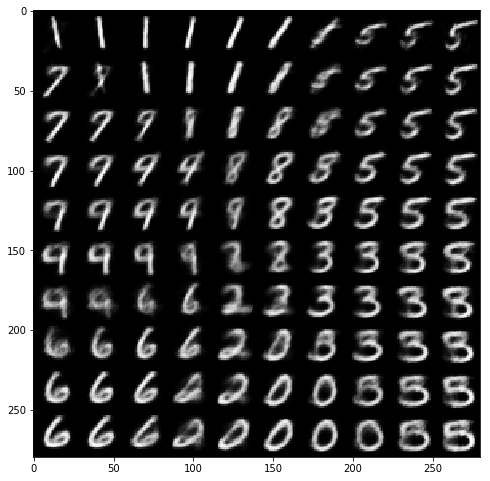

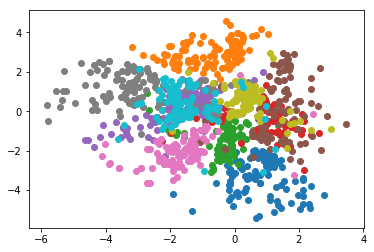

In [14]:
loss_op = vae_loss(decoder, tf.reshape(X, [-1, 28*28]))
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss_op)
sess.run(tf.global_variables_initializer())

train(50)
plot_generated()
plot_means()

The variational autoencoder ensures that the distribution of the dataset is ${\cal N}(0, 1)$.
If you do not enforce this with the kl loss (like a "normal" autoencoder) meaningful datapoints can be located anywhere and thus it is difficult to sample from it:

Epoch 0: loss 198221.1012
Epoch 1: loss 164891.8287
Epoch 2: loss 158216.6705
Epoch 3: loss 154577.2421
Epoch 4: loss 152324.5653
Epoch 5: loss 150668.6020
Epoch 6: loss 149312.7842
Epoch 7: loss 148132.3153
Epoch 8: loss 147066.6799
Epoch 9: loss 146093.8721
Epoch 10: loss 145196.1535
Epoch 11: loss 144373.8314
Epoch 12: loss 143615.0904
Epoch 13: loss 142917.1692
Epoch 14: loss 142276.9370
Epoch 15: loss 141684.5880
Epoch 16: loss 141134.4105
Epoch 17: loss 140620.8388
Epoch 18: loss 140139.9520
Epoch 19: loss 139692.7107
Epoch 20: loss 139267.0946
Epoch 21: loss 138868.0046
Epoch 22: loss 138489.9465
Epoch 23: loss 138137.7569
Epoch 24: loss 137797.0001
Epoch 25: loss 137471.0810
Epoch 26: loss 137163.3147
Epoch 27: loss 136870.8678
Epoch 28: loss 136587.9118
Epoch 29: loss 136317.8593
Epoch 30: loss 136060.6681
Epoch 31: loss 135811.6761
Epoch 32: loss 135570.7344
Epoch 33: loss 135340.6587
Epoch 34: loss 135118.1702
Epoch 35: loss 134903.5706
Epoch 36: loss 134697.9494
Epoch 37: l

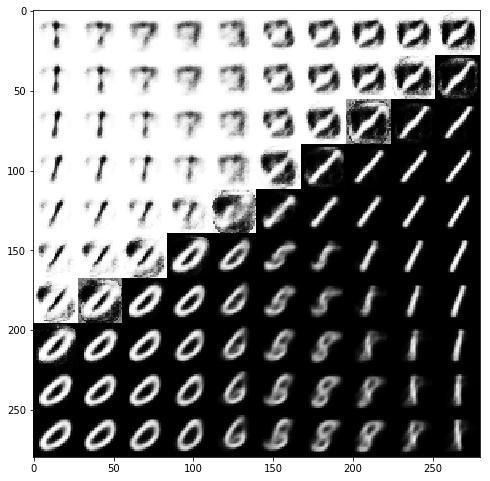

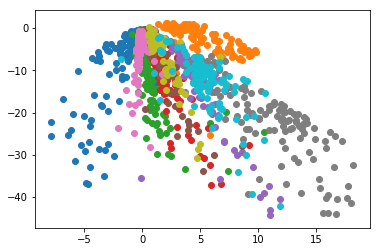

In [15]:
loss_op = vae_loss(decoder, tf.reshape(X, [-1, 28*28]), reconstruction_loss=True, kl_loss=False)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(loss_op)
sess.run(tf.global_variables_initializer())

train(50)
plot_generated()
plot_means()

But if you just use the kl loss, the datapoints will be mapped to the to the standard normal distribution, but the decoder does not re-construct meaningful data points:

Epoch 0: loss 457.6196
Epoch 1: loss 96.7508
Epoch 2: loss 40.7418
Epoch 3: loss 21.6816
Epoch 4: loss 14.4362
Epoch 5: loss 11.0783
Epoch 6: loss 9.2368
Epoch 7: loss 8.0681
Epoch 8: loss 7.2420
Epoch 9: loss 6.6134
Epoch 10: loss 6.1102
Epoch 11: loss 5.6929
Epoch 12: loss 5.3378
Epoch 13: loss 5.0297
Epoch 14: loss 4.7584
Epoch 15: loss 4.5168
Epoch 16: loss 4.2996
Epoch 17: loss 4.1028
Epoch 18: loss 3.9235
Epoch 19: loss 3.7591
Epoch 20: loss 3.6077
Epoch 21: loss 3.4676
Epoch 22: loss 3.3377
Epoch 23: loss 3.2166
Epoch 24: loss 3.1035
Epoch 25: loss 2.9975
Epoch 26: loss 2.8980
Epoch 27: loss 2.8043
Epoch 28: loss 2.7159
Epoch 29: loss 2.6324
Epoch 30: loss 2.5532
Epoch 31: loss 2.4781
Epoch 32: loss 2.4068
Epoch 33: loss 2.3389
Epoch 34: loss 2.2741
Epoch 35: loss 2.2124
Epoch 36: loss 2.1533
Epoch 37: loss 2.0969
Epoch 38: loss 2.0428
Epoch 39: loss 1.9909
Epoch 40: loss 1.9411
Epoch 41: loss 1.8933
Epoch 42: loss 1.8473
Epoch 43: loss 1.8031
Epoch 44: loss 1.7604
Epoch 45: los

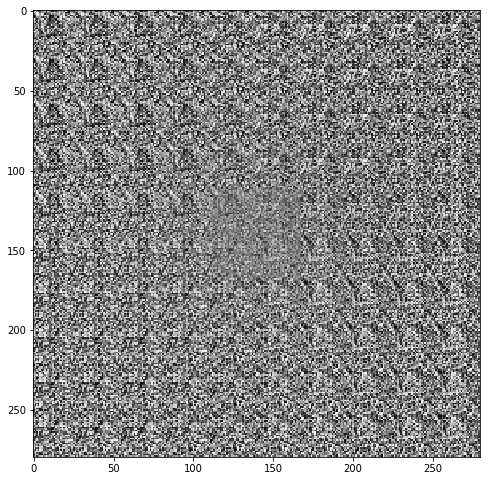

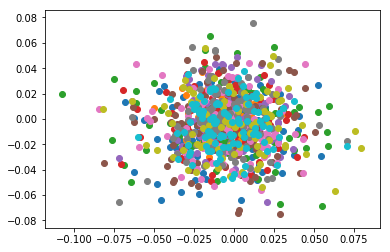

In [16]:
loss_op = vae_loss(decoder, tf.reshape(X, [-1, 28*28]), reconstruction_loss=False, kl_loss=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.00001)
train_op = optimizer.minimize(loss_op)
sess.run(tf.global_variables_initializer())

train(50)
plot_generated()
plot_means()

In [17]:
sess.close()